In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [2]:
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':100})
start_time = time()

energy_meters_df = pd.read_excel('data/VIS Målere.xlsx')
# Remove leading and trailing whitespace in cells with value of type string
energy_meters_df = energy_meters_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
raw_esave_tables_dict = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', decimal=',', sheet_name=None)
raw_esave_tables_list = raw_esave_tables_dict.values()
for table in raw_esave_tables_list:
    table.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    table['datetime'] = pd.to_datetime(table['datetime'], dayfirst=True)
    table.set_index('datetime', inplace=True)
    table.sort_index()
raw_esave_table = pd.concat(raw_esave_tables_list, axis=1, ignore_index=False)

stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to read xls files')

Used 87.86 seconds to read xls files


In [3]:
start_time = time()

buildings = {}
current_building = None
sensor_types = ['Fastkraft', 'Fjernvarme', 'Varme', 'Elkjel', 'Kjøling']
for _, row in energy_meters_df.iterrows():
    # if current row is a building not a sensor create a new dict to store all sensors for that building
    if row['Objekt'] == 'Bygg':
        current_building = {}
        for sensor_type in sensor_types:
            current_building[sensor_type] = {}
        buildings[row['Navn']] = current_building
        continue
    
    sensor_type = row['Type']
    if sensor_type in sensor_types:
        name = row['Navn']
        sensor_id = row['Formel']
        current_building[sensor_type][name] = sensor_id


stop_time = time()
elapsed_time = stop_time - start_time
print(f'Used {elapsed_time:.2f} seconds to parse')

Used 0.05 seconds to parse


In [4]:
# Create a dictionary that contains a dataframe for each building that have column for each sensor type (e.g. Fjernvarme or Fastkraft)
building_dfs = {}
for building_name, sensor_type_dict in buildings.items():

    sensor_type_series = {}
    for sensor_type, sensor_dict in sensor_type_dict.items():
        for sensor_id in sensor_dict.values():
            if sensor_id in raw_esave_table.columns:
                sensor_series = raw_esave_table[sensor_id]
                if not sensor_type in sensor_type_series:
                    sensor_type_series[sensor_type] = sensor_series
                else:
                    sensor_type_series[sensor_type] = sensor_type_series[sensor_type] + sensor_series
    if sensor_type_series:
        building_dfs[building_name] = pd.DataFrame(sensor_type_series)
        building_dfs[building_name].sort_index()

# Create a column in each building dataframe that is the total energy consumption, i.e. the sum of all other columns.
for building_df in building_dfs.values():
    building_df['Totalt'] = building_df[list(building_df.columns)].sum(axis=1)


In [5]:
# Create new data frames for each building that have values for each day or week instead of hourly
building_daily_dfs = {}
building_weekly_dfs = {}
for building_name, building_df in building_dfs.items():
    building_daily_dfs[building_name] = building_df.resample('D').sum()
    building_weekly_dfs[building_name] = building_df.resample('W-MON').sum()

# ET

In [6]:
energy_temperature_df = pd.read_excel('data/ET Kurver.xlsx')
# Remove leading and trailing whitespace in column names
energy_temperature_df.columns = energy_temperature_df.columns.str.strip()
# Remove leading and trailing whitespace in cells with value of type string
energy_temperature_df = energy_temperature_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [7]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, baseline, dx, dy):
        self.baseline = baseline
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series, threshold):
        expected_series = self.get_expected_series(temperature_series)
        mask = energy_series / expected_series >= (threshold + 1)
        return energy_series[mask]

In [8]:
def et_curve_from_pandas_row(row: pd.core.series.Series) -> et_curve:
    baseline = row['Grunnlast']

    dx = []
    dy = []
    for i in range(1,7):
        x = row[f'DX{i}']
        y = row[f'DY{i}']
        if (not np.isnan(x)) and (not np.isnan(y)):
            dx.append(x)
            dy.append(y)

    return et_curve(baseline, dx, dy)

def get_latest_et_curve_from_dict(et_curve_dict):
    key = max(et_curve_dict.keys())
    return et_curve_dict[key]

In [9]:
et_curves_dict = {}
for _, row in energy_temperature_df.iterrows():
    building_name = row['Bygg']

    valid_from_str = row['Fra']
    valid_from = datetime.strptime(valid_from_str, '%d.%m.%Y')

    building_et_curve = et_curve_from_pandas_row(row)

    if not building_name in et_curves_dict:
        et_curves_dict[building_name] = {}
    
    et_curves_dict[building_name][valid_from] = building_et_curve

-30 is below range, lowest point is (-12.6, 8518.9)
-29 is below range, lowest point is (-12.6, 8518.9)
-28 is below range, lowest point is (-12.6, 8518.9)
-27 is below range, lowest point is (-12.6, 8518.9)
-26 is below range, lowest point is (-12.6, 8518.9)
-25 is below range, lowest point is (-12.6, 8518.9)
-24 is below range, lowest point is (-12.6, 8518.9)
-23 is below range, lowest point is (-12.6, 8518.9)
-22 is below range, lowest point is (-12.6, 8518.9)
-21 is below range, lowest point is (-12.6, 8518.9)
-20 is below range, lowest point is (-12.6, 8518.9)
-19 is below range, lowest point is (-12.6, 8518.9)
-18 is below range, lowest point is (-12.6, 8518.9)
-17 is below range, lowest point is (-12.6, 8518.9)
-16 is below range, lowest point is (-12.6, 8518.9)
-15 is below range, lowest point is (-12.6, 8518.9)
-14 is below range, lowest point is (-12.6, 8518.9)
-13 is below range, lowest point is (-12.6, 8518.9)
21 is above range, highest point is (20.0, 1930.3)
22 is above r

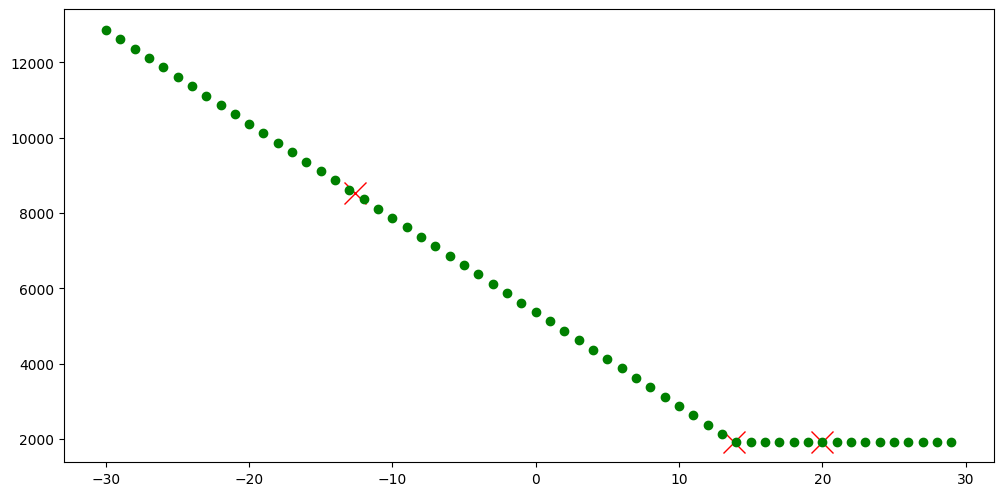

In [10]:
test_building_name = 'Trondheim Kommune - Aastahagen barnehage'

test_et = None
newest_date = datetime(1971, 1, 1)
for date, et in et_curves_dict[test_building_name].items():
    if date > newest_date:
        test_et = et

for x, y in zip(test_et.dx, test_et.dy):
    plt.plot(x, y, 'rx', markersize=16)

for x in range(-30, 30):
    prediction = test_et.expected(x)
    # print(f'temp: {x} expected: {prediction:.1f} kWh/uke')
    plt.plot(x, prediction, 'go')

plt.show()

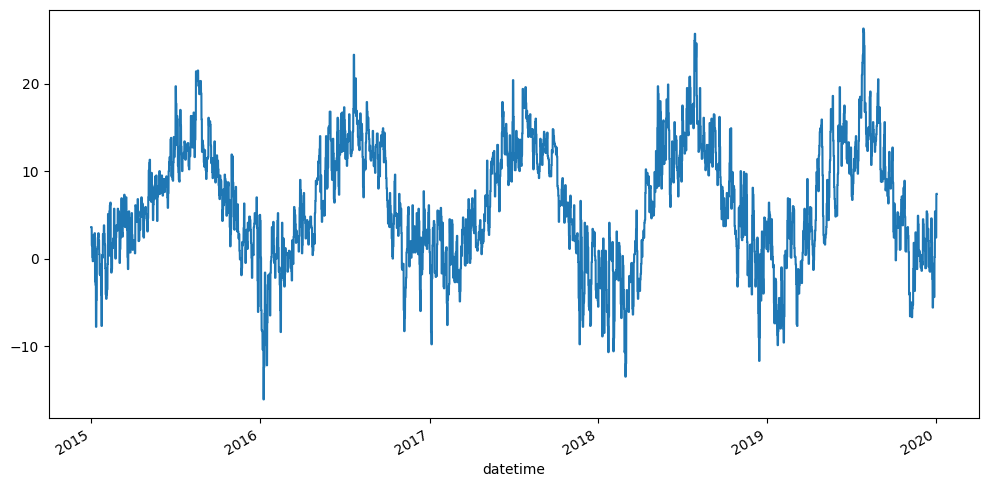

In [11]:
temp_voll = raw_esave_table['Eklima_68860_TAM']
temp_voll.plot()
plt.show()

In [12]:
temp_voll_weekly_mean = temp_voll.resample('W-MON').mean()

In [13]:
et_prediction_weekly = temp_voll_weekly_mean.apply(test_et.expected)

20.67083333333333 is above range, highest point is (20.0, 1930.3)
22.99404761904762 is above range, highest point is (20.0, 1930.3)


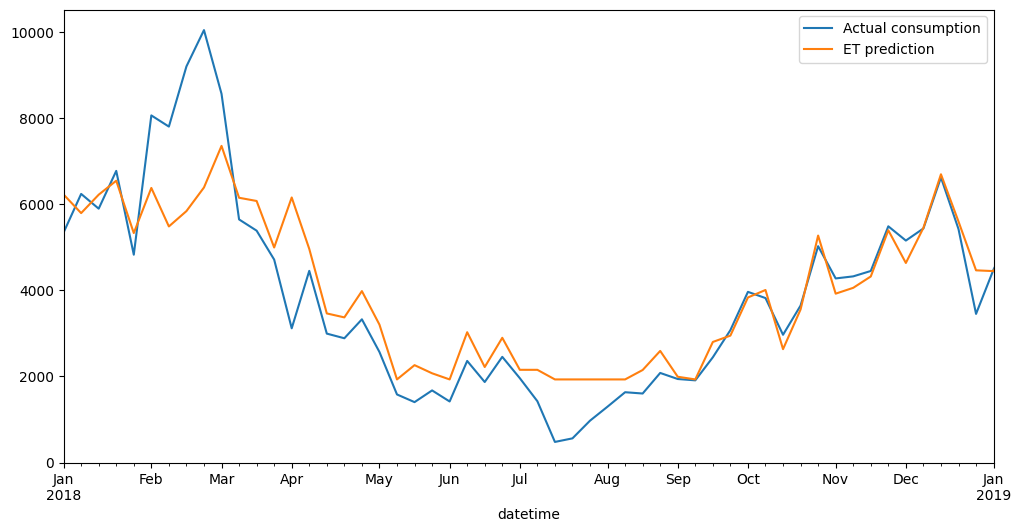

In [14]:
start_plot = datetime(2018, 1, 1)
stop_plot = datetime(2019, 1, 1)

consumption_subplot = building_weekly_dfs[test_building_name]['Totalt'].plot(xlim=(start_plot, stop_plot))
prediction_subplot = et_prediction_weekly.plot(xlim=(start_plot, stop_plot))
plt.legend(['Actual consumption', 'ET prediction'])
plt.show()

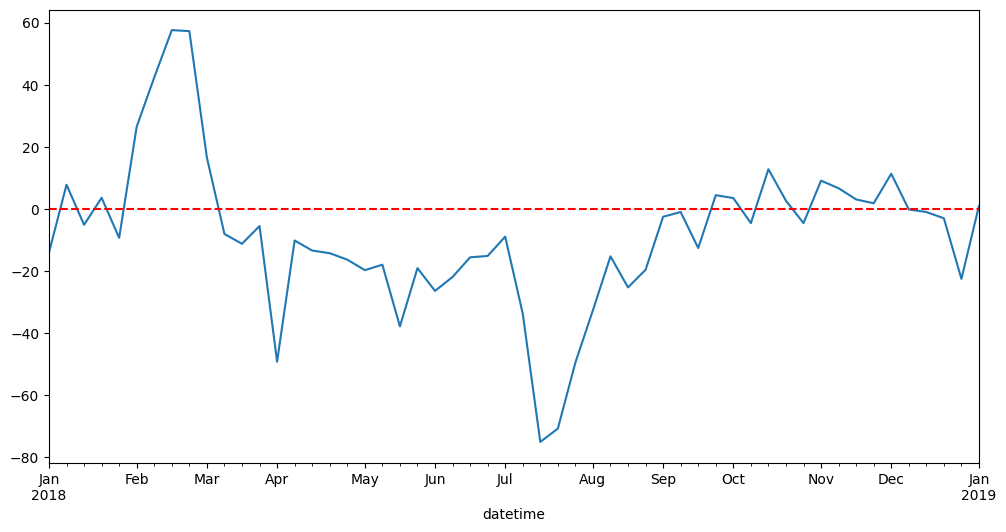

In [15]:
energy_consumption_difference_weekly_et = building_weekly_dfs[test_building_name]['Totalt'] - et_prediction_weekly
energy_consumption_difference_proportional_weekly_et = energy_consumption_difference_weekly_et / et_prediction_weekly
energy_consumption_difference_precent_weekly_et = energy_consumption_difference_proportional_weekly_et * 100

energy_consumption_difference_precent_weekly_et.plot(xlim=(start_plot, stop_plot))
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [16]:
anomolies_series = test_et.get_anomolies_series(building_weekly_dfs[test_building_name]['Totalt'], temp_voll_weekly_mean, 0.15)

20.67083333333333 is above range, highest point is (20.0, 1930.3)
22.99404761904762 is above range, highest point is (20.0, 1930.3)


In [17]:
anomolies_series.shape

(9,)

In [18]:
building_weekly_dfs[test_building_name]['Totalt'].shape

(262,)

<AxesSubplot:xlabel='datetime'>

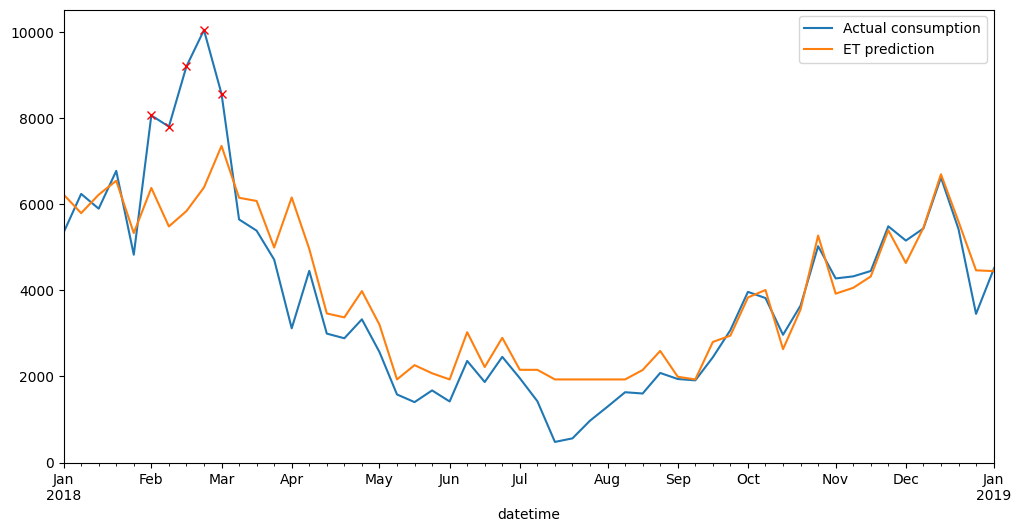

In [19]:
building_weekly_dfs[test_building_name]['Totalt'].plot(xlim=(start_plot, stop_plot))
et_prediction_weekly.plot(xlim=(start_plot, stop_plot))
plt.legend(['Actual consumption', 'ET prediction'])

plt.legend
anomolies_series.plot(style="rx", xlim=(start_plot, stop_plot))


20.67083333333333 is above range, highest point is (20.0, 754.0)
22.99404761904762 is above range, highest point is (20.0, 754.0)
20.67083333333333 is above range, highest point is (20.0, 1400.0)
22.99404761904762 is above range, highest point is (20.0, 1400.0)
20.67083333333333 is above range, highest point is (20.0, 962.2)
22.99404761904762 is above range, highest point is (20.0, 962.2)
-9.342857142857143 is below range, lowest point is (-8.4, 3301.9)
20.67083333333333 is above range, highest point is (20.0, 839.6)
22.99404761904762 is above range, highest point is (20.0, 839.6)
20.67083333333333 is above range, highest point is (20.0, 1250.9)
22.99404761904762 is above range, highest point is (20.0, 1250.9)
20.67083333333333 is above range, highest point is (20.0, 1581.1)
22.99404761904762 is above range, highest point is (20.0, 1581.1)
20.67083333333333 is above range, highest point is (20.0, 1200.0)
22.99404761904762 is above range, highest point is (20.0, 1200.0)
20.6708333333333

<AxesSubplot:xlabel='datetime'>

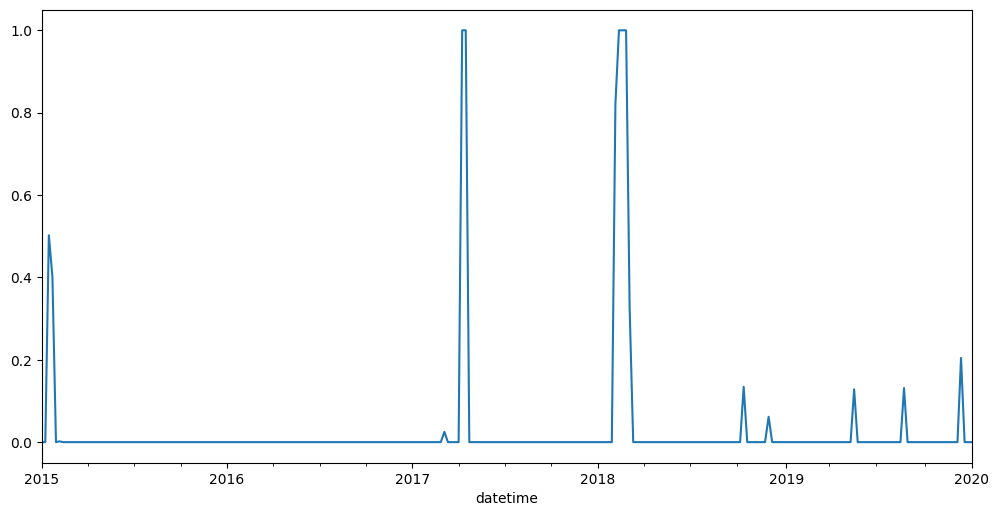

In [20]:
def anomaly_prediction_function(proportian_value):
    min_v = 1.10
    max_v = 1.30
    return max(min((proportian_value - min_v) / (max_v - min_v), 1), 0)


anomaly_prediction_dict = {}
for building_name, et_dict in et_curves_dict.items():
    if building_name not in building_weekly_dfs:
        print(f'{building_name} not in building_weekly dfs')
        continue

    energy_consumption_series = building_weekly_dfs[building_name]['Totalt']
    
    latest_et: et_curve = get_latest_et_curve_from_dict(et_dict)
    consumption_prediction_proportion = latest_et.get_proportial_series(energy_consumption_series, temp_voll_weekly_mean)
    anomaly_series = consumption_prediction_proportion.apply(anomaly_prediction_function)

    anomaly_prediction_dict[building_name] = anomaly_series

anomaly_prediction_df = pd.DataFrame(anomaly_prediction_dict)
anomaly_prediction_df[test_building_name].plot()

In [21]:
with pd.ExcelWriter(
    'data/et_curve_anomaly_confidence.xlsx',
    
) as writer:
    anomaly_prediction_df.to_excel(writer, float_format='%.2f')